In [1]:
import itertools
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Functions

In [2]:
def clean_data(raw, z_threshold=2.5, min_listen_time=20):
    """
    Drops entries with abnormal listening_time (z-score too high or time too low).
    Also removes entries with unknown origin
    :param min_listen_time: entries where the user has listened for less than this (s) are dropped
    :param z_threshold: maximum z-score allowed in the dataset
    :param raw: raw data to be processed
    :return: clean dataset (pd.DataFrame)
    """
    print("Computing z-score...")
    z = np.abs(stats.zscore(raw["listening_time"]))

    print("Cleaning...")
    # Entries with a z-score above the threshold will be dropped (also instant-skips of listening_time < X)
    raw.drop(raw[z > z_threshold].index, inplace=True)
    raw.drop(raw[raw.listening_time < min_listen_time].index, inplace=True)
    return raw[(raw["origin"] != "unknown")]

In [3]:
def is_reco(origin):
    return origin[:3] == "rec" or origin == "flow"

In [4]:
def bin_artists(data, bin_amnt=25, separate_reco=True):
    """
    takes in raw data from streams (with added art_id -- see "formatting/add_artists.py") and bins artists together
    according to their "mainstream" status -- i.e. how much they are listened to.
    :param bin_amnt: amount of bins the artists will be put into AT MOST
    :param separate_reco: Whether or not to add a "recommended" column to the DF
    :param data: DataFrame ["user_id", "ts", "sng_id", "album_id", "listening_time", "listen_type", "origin", "art_id"]
    :return: the same DataFrame with added columns [..., "bin_nb", "recommended"] -- unless recommended is not wanted
    """
    print("Counting artist occurences...")
    artist_count = data["art_id"].value_counts(normalize=False).sort_values(ascending=True).to_frame() \
        .reset_index().rename(columns={"index": "art_id", "art_id": "plays"})
    artist_count["cumplays"] = artist_count["plays"].cumsum()

    print("Binning artists...")
    # Cutting into bin_amnt bins (duplicate bins allowed -- and necessary for small datasets and large amount of bins)
    artist_count["bin"] = pd.cut(artist_count["cumplays"], bin_amnt, duplicates="drop")
    print(f"Number of artists per bin: \n{artist_count.groupby('bin').size()}")

    # Assigning corresponding numbers to bins
    artist_count["bin_nb"] = (artist_count["bin"].cat.codes + 1).values
    print(f"Artists binned into {artist_count['bin_nb'].max()} categories.")

    data = data.merge(artist_count[["art_id", "bin_nb"]], left_on="art_id", right_on="art_id")

    # Adding 'recommended' column
    if separate_reco:
        data["recommended"] = data["origin"].map(is_reco)

    return data

In [5]:
def get_user_frame(data, bin_distribution):
    # Vectorized computing of the users' bin ratios
    user_frame = main_dist.to_frame()
    user_frame.columns = ["ratio"]

    # Our user_frame ends up with [user, bin_nb, ratio]
    user_plays = user_frame["ratio"].sum(level=0)
    user_frame = user_frame.unstack('bin_nb').divide(bin_distrib, level=1).divide(user_plays, axis=0).stack("bin_nb")

    user_frame = user_frame.reset_index()
    
    return user_frame

In [6]:
FILE_NAME = "../../data/artist_streams.csv"
SAVE_NAME = "../../data/mainstream_data.csv"
MIN_OBS = 100
SEPARATE_RECO = False
BIN_AMNT = 4

sns.set_palette(sns.color_palette("colorblind"))
sns.set_style("darkgrid")

In [7]:
print("Reading data...")
raw_data = pd.read_csv(FILE_NAME)
raw_data = clean_data(raw_data, z_threshold=3)
print(f"Data shape: {raw_data.shape[0]} lines, {raw_data.shape[1]} columns")

Reading data...
Computing z-score...
Cleaning...
Data shape: 1368080 lines, 8 columns


In [8]:
# Bin artists together
artist_data = bin_artists(raw_data, BIN_AMNT, SEPARATE_RECO)

print(f"Standard deviation of amount of plays per bin: {np.std(artist_data.groupby(['bin_nb']).size().values)}")

Counting artist occurences...
Binning artists...
Number of artists per bin: 
bin
(-1367.079, 342020.75]     7679
(342020.75, 684040.5]       437
(684040.5, 1026060.25]      135
(1026060.25, 1368080.0]      44
dtype: int64
Artists binned into 4 categories.
Standard deviation of amount of plays per bin: 584.0530797795693


In [9]:
 # Occurences of music plays in each bin
bin_distrib = artist_data.groupby("bin_nb").size()

# Reversing bin numbers -- just a dirty little workaround to have the "mainstreamest" bin be 1
artist_data["bin_nb"] = BIN_AMNT+1 - artist_data["bin_nb"]

# Normalized
bin_distrib /= bin_distrib.sum()

In [10]:
# Grouping users and their artist bin consumption
main_dist = artist_data.groupby(["user_id", "recommended", "bin_nb"] if SEPARATE_RECO
                                else ["user_id", "bin_nb"]).size()

print(f"Removing users with fewer than {MIN_OBS} observations...")
remove_idx = artist_data.groupby(["user_id"]).size()
remove_idx = remove_idx[remove_idx < MIN_OBS].index.unique()

main_dist.drop(labels=remove_idx, inplace=True)
print(f"Removed {len(remove_idx)} users.")

Removing users with fewer than 100 observations...
Removed 9 users.


In [11]:
print("Analyzing users...")
test_users = np.random.choice(main_dist.index.get_level_values("user_id").unique(), 6, replace=False)
recommended_choices = [True, False]
aggregate = pd.DataFrame(columns=["user_id", "recommended", "bin_nb", "ratio"])

Analyzing users...


# Users pre-binning based on recommendation usage

In [37]:
# Determining rate of recommended to organic for users
artist_data["recommended"] = artist_data["origin"].map(is_reco)
users_reco = artist_data.groupby(["user_id", "recommended"]).size().reset_index()
users_reco.columns = ["user_id", "recommended", "amnt"]

# Checking if all users have both types before division
users_reco_types = users_reco.groupby(["user_id"]).size()
users_reco_types = list(users_reco_types[users_reco_types == 1].index)

# Adding True column for False-only users and vice-versa
to_add = users_reco[users_reco["user_id"].isin(users_reco_types)]
to_add.loc[:, "recommended"] = ~to_add["recommended"]
# Not using 0 to avoid divisions -- in practice, this won't affect the bins
to_add.loc[:, "amnt"] = 1
users_reco = users_reco.append(to_add).sort_values(by=["user_id"])

users_reco.loc[:, "rate"] = 0
rec_amnts = users_reco[users_reco["recommended"] == True]["amnt"].values
org_amnts = users_reco[users_reco["recommended"]== False]["amnt"].values

# Changing users_reco into the final DataFrame
users_reco = users_reco[users_reco.recommended == True].drop(["recommended", "amnt"], axis=1)
users_reco.loc[:, "rate"] = rec_amnts / (rec_amnts + org_amnts)


# Adding nb of plays to users_reco in order to form bins with equal amounts of plays
users_reco = main_dist.groupby("user_id").sum().to_frame().merge(users_reco, left_on="user_id", right_on="user_id").sort_values("rate", ascending=True)
users_reco["cumplays"] = users_reco[0].cumsum()
users_reco

c:\users\quentin\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,user_id,0,rate,cumplays
996,faca30a972889b9f9dbe48fff9cc48929dc4c83b,4675,0.000214,4675
406,6543e42f5cfc84cfe2fb093d72b58b338dae4880,3213,0.000311,7888
754,b9115fc11d1a49ca11b1eff5d3d21dd96ed12720,2887,0.000346,10775
874,dac91821e5e928765ffcb26f5226d97f8894388c,8438,0.000356,19213
471,772454490ca8d33ffbd714e1b7614fd9f4940ecb,2720,0.000368,21933
...,...,...,...,...
653,9ff0a9ae1feee5bc83ab036558f4314f557f23c8,2219,0.900406,1362691
88,199b748f1902835734469bb8d9df38a91d3b6d91,1160,0.903448,1363851
123,2600ac94a475cf35303616de09d915c740a67386,2007,0.927753,1365858
205,39610b7c24ff424b8f242aa4f13da6765717f877,681,0.951542,1366539


Number of users per bin: 
u_bin
(3311.84, 686255.0]      515
(686255.0, 1367835.0]    498
dtype: int64
Users binned into 2 categories.


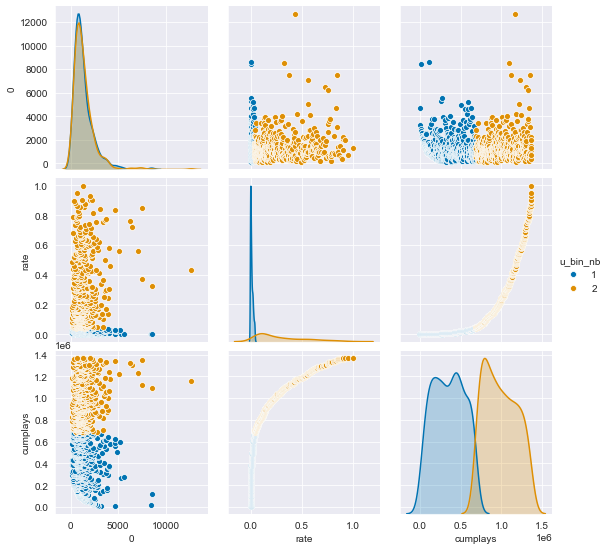

0.04285714285714286
0.04433760683760684
0.044444444444444446


In [38]:
USER_BINS = 2
# Cutting into bins
users_reco["u_bin"] = pd.cut(users_reco["cumplays"], USER_BINS, duplicates="drop")
print(f"Number of users per bin: \n{users_reco.groupby('u_bin').size()}")

# Assigning corresponding numbers to bins
users_reco["u_bin_nb"] = (users_reco["u_bin"].cat.codes + 1).values
print(f"Users binned into {users_reco['u_bin_nb'].max()} categories.")
sns.pairplot(users_reco, hue="u_bin_nb")
plt.show()
print(users_reco["rate"].median())
print(users_reco[users_reco["u_bin_nb"] == 1]["rate"].max())
print(users_reco[users_reco["u_bin_nb"] == 2]["rate"].min())

users_reco.drop(["u_bin", "rate"], axis=1, inplace=True)

# sns.distplot(users_reco[users_reco["bin_nb"] == 4]["rate"], kde=False)

In [13]:
# Amount of plays per user bin
main_dist.groupby("user_id").sum().to_frame().merge(users_reco, left_on="user_id", right_on="user_id").groupby("u_bin_nb").sum()

,0_x,0_y,cumplays
u_bin_nb,,,
1,685190,685190,183473421
2,682645,682645,494175944


In [14]:
# Testing correctness of user frame ratios
# user_frame = get_user_frame(main_dist, bin_distrib)
# user_frame.groupby("user_id")["ratio"].sum().values.mean()

user_frame = get_user_frame(main_dist, bin_distrib).merge(users_reco, left_on="user_id", right_on="user_id").drop(["user_id"], axis=1)

# Geometric mean
# user_bin_ratios = user_frame.groupby(["u_bin_nb", "bin_nb"])["ratio"].apply(stats.gmean).to_frame().reset_index()
user_bin_ratios = user_frame.groupby(["u_bin_nb", "bin_nb"])["ratio"].apply(np.mean).to_frame().reset_index()

print(user_bin_ratios.groupby("u_bin_nb")["ratio"].sum().values.mean())

# Log ratio
user_bin_ratios["ratio"] = user_bin_ratios["ratio"].map(np.log)

4.013059365960039


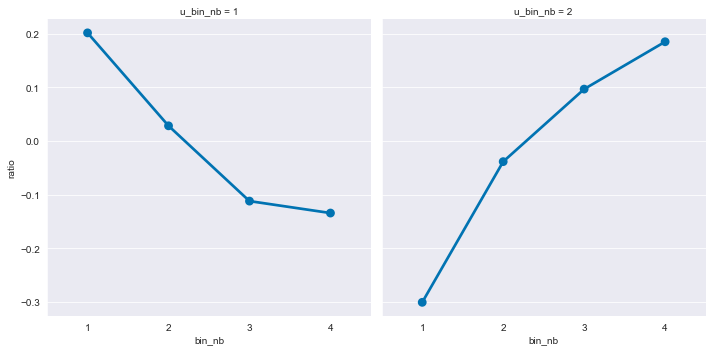

In [15]:
# Plotting the first users
sns.catplot(x="bin_nb", y="ratio", kind="point", col="u_bin_nb", col_wrap=2, data=user_bin_ratios, legend=False)

# Computing bin_distrib -- Vectorized version

In [135]:
user_frame = get_user_frame(main_dist, bin_distrib)

In [186]:
# Saving frame
user_frame.to_csv("mainstream_ratios.csv", index=False)

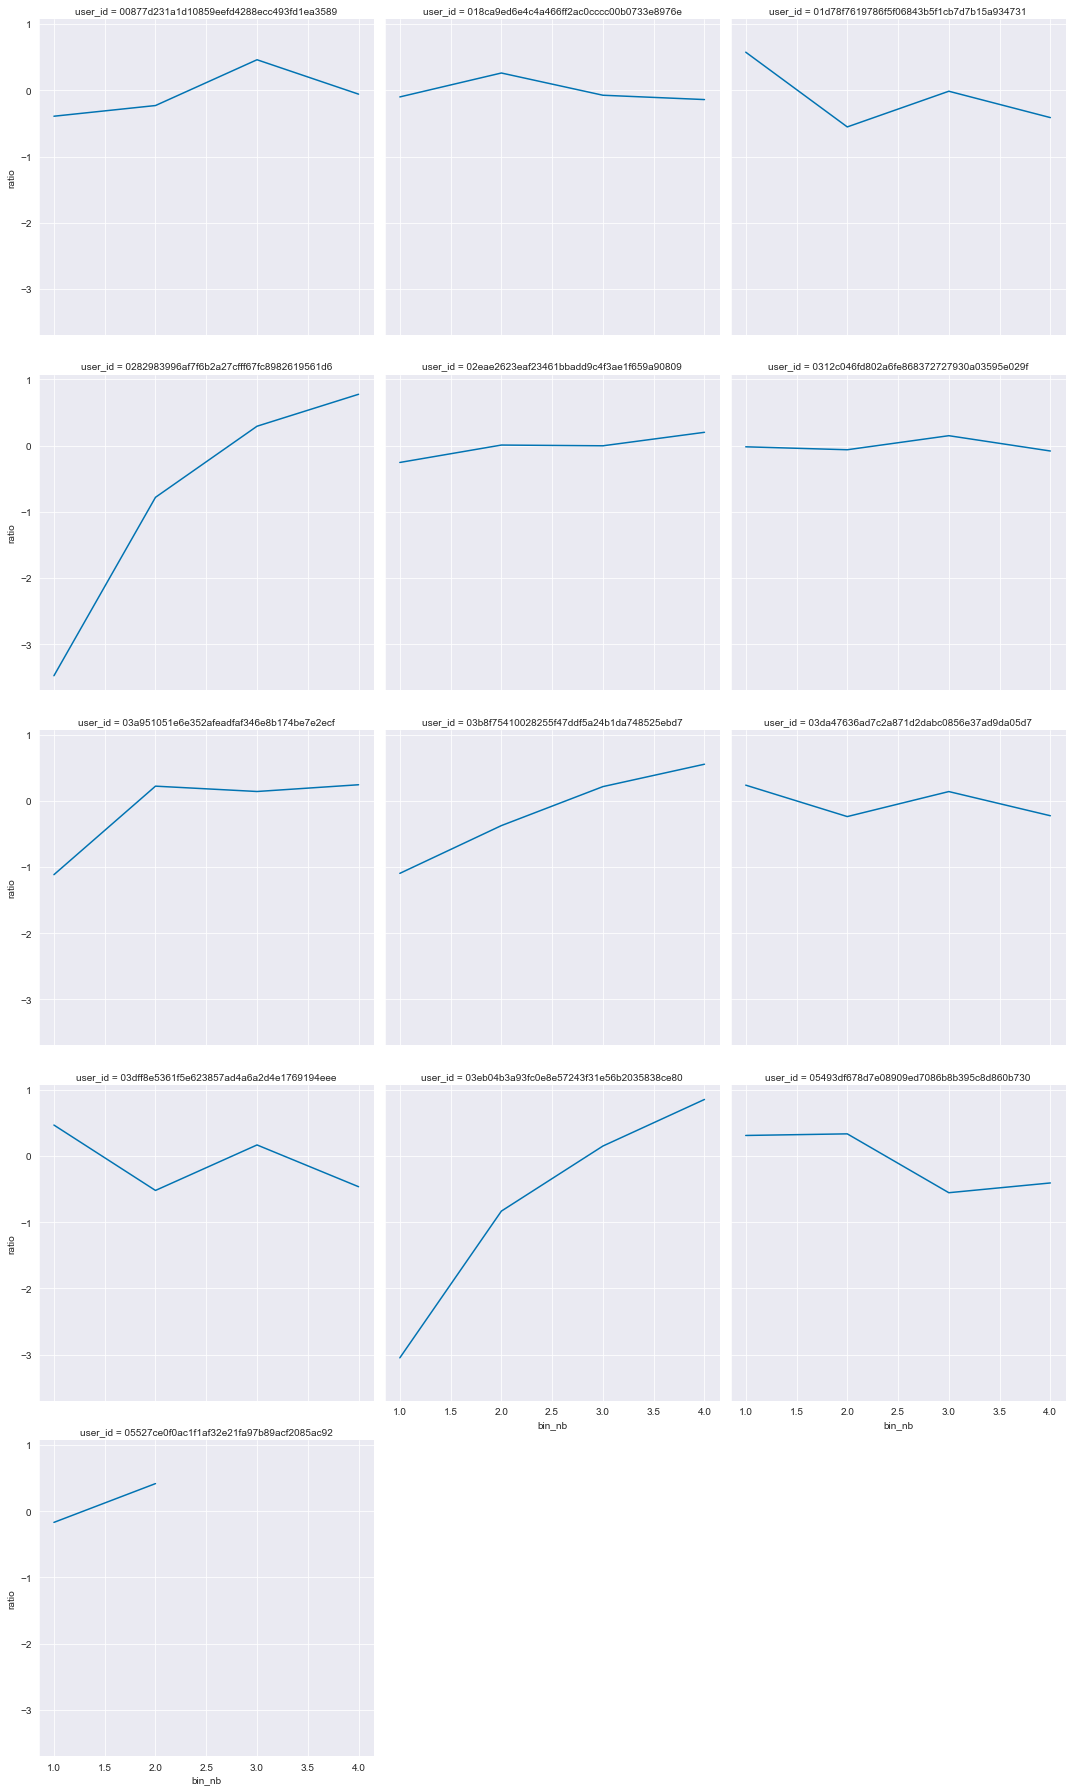

In [136]:
# Log for ratio
user_frame["ratio"] = user_frame["ratio"].map(np.log)

#Plotting the first users
sns.relplot(x="bin_nb", y="ratio", kind="line", col="user_id", col_wrap=3, dashes=False, markers=True,
            estimator=None, data=user_frame[:50], legend=False)

# Are recommendations favorizing mainstream content?

In [20]:
reco_mainstream = artist_data.merge(users_reco, left_on="user_id", right_on="user_id").drop(["ts", "listen_type", "listening_time", "album_id", "sng_id", "origin"], axis=1)

# For each user bin (recommendation based grouping)
reco_mainstream = reco_mainstream.groupby(["bin_nb", "u_bin_nb", "recommended"]).size()
reco_mainstream = reco_mainstream.to_frame().reset_index()
reco_mainstream.columns = ["bin_nb", "u_bin_nb", "recommended", "amount"]

# Testing stuff right there -- loop version because I have no idea how to vectorize this for now
test = reco_mainstream.groupby(["u_bin_nb", "recommended"]).mean().reset_index()

reco_mainstream["amount"] = reco_mainstream["amount"].astype(float)

for i, row in reco_mainstream.iterrows():
    reco_mainstream.at[i, "amount"] /= test[(test["u_bin_nb"] == reco_mainstream.at[i, "u_bin_nb"]) & (test["recommended"] == reco_mainstream.at[i, "recommended"])]["amount"]

# Mean mainstream bin for recommended vs. organic
test = reco_mainstream.groupby(["bin_nb", "recommended"])["amount"].sum().to_frame().reset_index()
print(test)
test_org = test[test["recommended"] == False]
test_rec = test[test["recommended"] == True]
print(f'Mean mainstream bin for organic plays: {(test_org["amount"] * test_org["bin_nb"]).sum() / test_org["amount"].sum()}')
print(f'Mean mainstream bin for recommended plays: {(test_rec["amount"] * test_rec["bin_nb"]).sum() / test_rec["amount"].sum()}')

# Log ratio
reco_mainstream["amount"] = reco_mainstream["amount"].map(np.log)
0
reco_mainstream

    bin_nb  u_bin_nb  recommended    amount
0        1         1        False  214200.0
1        1         1         True    1593.0
2        1         2        False  100223.0
3        1         2         True   26981.0
4        2         1        False  174813.0
5        2         1         True    1925.0
6        2         2        False  113684.0
7        2         2         True   51365.0
8        3         1        False  147680.0
9        3         1         True    2341.0
10       3         2        False  117797.0
11       3         2         True   73692.0
12       4         1        False  140351.0
13       4         1         True    2287.0
14       4         2        False  124863.0
15       4         2         True   74040.0
   bin_nb  recommended    amount
0       1        False  2.143559
1       1         True  1.259599
2       2        False  2.028791
3       2         True  1.854051
4       3        False  1.904522
5       3         True  2.453354
6       4        Fals

,bin_nb,u_bin_nb,recommended,amount
0,1,1,False,0.235468
1,1,1,True,-0.245614
2,1,2,False,-0.130043
3,1,2,True,-0.739453
4,2,1,False,0.032275
5,2,1,True,-0.056307
6,2,2,False,-0.004018
7,2,2,True,-0.095629
8,3,1,False,-0.136394
9,3,1,True,0.139346


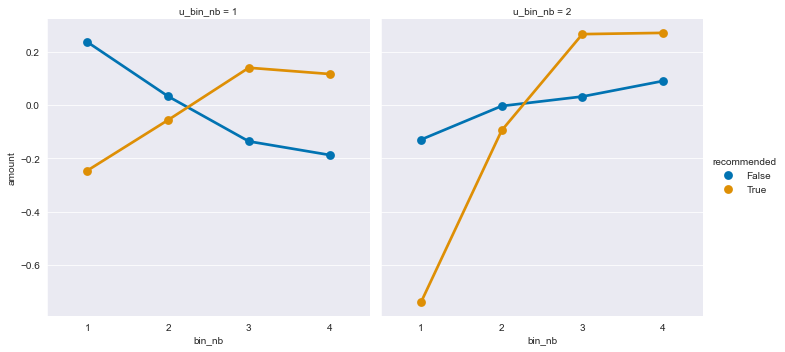

In [17]:
sns.catplot(x="bin_nb", y="amount", col="u_bin_nb", col_wrap=2, hue="recommended", kind="point", data=reco_mainstream)

## Are organic non-mainstream listenings the result of previous recommendations?

In [71]:
# Finding songs for each user that were listened to only once 
single_listens = artist_data.groupby(["user_id", "sng_id"]).size()
single_listens = single_listens[single_listens < 2].to_frame().index

# Removing singletons from dataset
data_no_singletons = (artist_data[~pd.Series(list(zip(artist_data['user_id'], artist_data['sng_id']))).isin(single_listens)])[["user_id", "ts", "sng_id", "recommended"]]
data_no_singletons.sort_values(by=["user_id", "ts"], inplace=True)
data_no_singletons = data_no_singletons.reset_index().drop("index", axis=1)

# Removing non-valid timestamps (aberrant values and timestamps outside the bulk of the dataset)
normal_size = len(data_no_singletons.index)
data_no_singletons.drop(data_no_singletons[data_no_singletons["ts"] < 1470000000].index, inplace=True)

# Removing the first month of data to try and ensure most of the first listens are actually first listens
min_ts = data_no_singletons["ts"].min() + 2592000
print(data_no_singletons.sort_values(by="ts"))
data_no_singletons = data_no_singletons[data_no_singletons["ts"] > min_ts]

print(f"Removed {normal_size - len(data_no_singletons.index)} entries")

data_no_singletons

                                          user_id          ts     sng_id  \
211806   3469c83b7d77d585a7de6ffc0d5cf76e61a10181  1470017200  127246869   
628582   80b539655dd8d85966e4d8a19a0b73e414f5680b  1470039290  121597754   
628583   80b539655dd8d85966e4d8a19a0b73e414f5680b  1470039564  121597754   
62798    10a873050ba0da4db73358d3cb47ca215d918443  1470042918   76347353   
62799    10a873050ba0da4db73358d3cb47ca215d918443  1470043299   73949552   
...                                           ...         ...        ...   
168977   29567f16c8427e8f0e03215fef9f370fd10b396d  1479858868  124603270   
909102   c1cac6f9b4bd53ceda62e4542cd649c8af89fbe2  1479858877  104215432   
994172   d51e2a932ec75db360a2f3c830bb0f7d366c8444  1479858898  112736678   
251567   3e8acd193b7410061ed8aeb65f891d000f7e53ed  1479858960   66660698   
1146817  f5d323185d799c715d25928367e25cd99faeb331  1479859001    1118207   

         recommended  
211806         False  
628582         False  
628583         Fal

,user_id,ts,sng_id,recommended
766,00877d231a1d10859eefd4288ecc493fd1ea3589,1472650438,1579474,True
767,00877d231a1d10859eefd4288ecc493fd1ea3589,1472650561,68953820,True
768,00877d231a1d10859eefd4288ecc493fd1ea3589,1472650594,2958765,True
769,00877d231a1d10859eefd4288ecc493fd1ea3589,1472650693,70266759,True
770,00877d231a1d10859eefd4288ecc493fd1ea3589,1472650842,65672691,True
...,...,...,...,...
1174568,ff82befb6c2bcf11c638706bc27cf787128426de,1479497155,108692368,False
1174569,ff82befb6c2bcf11c638706bc27cf787128426de,1479538385,108692368,False
1174570,ff82befb6c2bcf11c638706bc27cf787128426de,1479538643,108692368,False
1174571,ff82befb6c2bcf11c638706bc27cf787128426de,1479711552,108692368,False


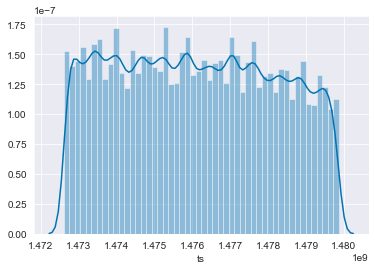

In [72]:
sns.distplot(data_no_singletons["ts"])

In [73]:
# Loop form -- maybe vectorizable at some point?
current_user = ""
reco_orga_table = pd.DataFrame(columns=["user_id", "sng_id", "org_to_rec"])
for i, row in data_no_singletons.iterrows():
    if current_user != row["user_id"]:
        # New user -- soft reset
        current_user = row["user_id"]
        user_dict = {}
    
    if row["sng_id"] not in user_dict:
        user_dict[row["sng_id"]] = row["recommended"]
    else:
        if row["recommended"] != user_dict[row["sng_id"]]:
            # Listen type different from the first time
            if (reco_orga_table[(reco_orga_table["user_id"] == current_user) & (reco_orga_table["sng_id"] == row["sng_id"])]).empty:
#             if [current_user, row["sng_id"]] not in reco_orga_table[reco_orga_table.columns[:2]].values:
                # Value not yet in the table
                reco_orga_table = pd.concat([reco_orga_table, pd.DataFrame([[current_user, row["sng_id"], row["recommended"]]], columns=["user_id", "sng_id", "org_to_rec"])],
                                           ignore_index=True)
                
    if i % 50000 == 0:
        print(i)

reco_orga_table

100000
150000
200000
300000
350000
400000
450000
500000
550000
600000
650000
750000
850000
900000
950000
1000000
1100000
1150000


,user_id,sng_id,org_to_rec
0,00877d231a1d10859eefd4288ecc493fd1ea3589,95938334,False
1,00877d231a1d10859eefd4288ecc493fd1ea3589,67354825,True
2,00877d231a1d10859eefd4288ecc493fd1ea3589,66465550,True
3,00877d231a1d10859eefd4288ecc493fd1ea3589,7379246,True
4,00877d231a1d10859eefd4288ecc493fd1ea3589,106152016,False
...,...,...,...
26260,fea927761d221701b2bf1b6acc2de6d91d060071,14615940,False
26261,ff7672529f1387bf35e1296f79009275287980a8,70506864,True
26262,ff7672529f1387bf35e1296f79009275287980a8,123883254,True
26263,ff7672529f1387bf35e1296f79009275287980a8,4619466,True


In [21]:
reco_orga_table.to_csv("reco_orga_table.csv", index=False)

In [27]:
reco_orga_table = pd.read_csv("reco_orga_table.csv")

In [74]:
song_bins = artist_data[["sng_id", "bin_nb"]].drop_duplicates().reset_index().drop(["index"], axis=1)

# Adding mainstream bins to reco_orga_table
reco_orga_table = reco_orga_table.merge(song_bins[["sng_id", "bin_nb"]], left_on="sng_id", right_on="sng_id")
reco_orga_table

,user_id,sng_id,org_to_rec,bin_nb
0,00877d231a1d10859eefd4288ecc493fd1ea3589,95938334,False,1
1,0943b6f3d8526ade6955c59d70a6636da0615589,95938334,True,1
2,111f74340b5ef733f7dc99dc5494de3da4dbeea7,95938334,True,1
3,1c6c921633d6f852294f2b22c42c00cd86abf9c9,95938334,True,1
4,2eb6426e60c908dd16ebfd5ae1f63555a1e07c5e,95938334,True,1
...,...,...,...,...
26260,fe016f7c946213bd53ca9b683b7314d24d2dbba9,109182794,True,4
26261,fe016f7c946213bd53ca9b683b7314d24d2dbba9,62986059,True,4
26262,fe016f7c946213bd53ca9b683b7314d24d2dbba9,73706048,False,4
26263,fe22a3978a595c3a63cb40558db7804956f8e1d7,908995,True,3


In [75]:
reco_orga_count = reco_orga_table.groupby(["bin_nb", "org_to_rec"]).size().to_frame().reset_index()
reco_orga_count.columns = ["bin_nb", "org_to_rec", "count"]
reco_orga_count

,bin_nb,org_to_rec,count
0,1,False,1486
1,1,True,3374
2,2,False,2449
3,2,True,4035
4,3,False,3191
5,3,True,4552
6,4,False,2878
7,4,True,4300


In [76]:
# Normalization
means = reco_orga_count.groupby(["bin_nb"]).sum().reset_index()

reco_orga_count["count"] = reco_orga_count["count"].astype(float)
for i, row in reco_orga_count.iterrows():
    reco_orga_count.at[i, "count"] /= means[means["bin_nb"] == row["bin_nb"]]["count"]
    
# No need to keep org_to_rec==True
reco_orga_count = reco_orga_count[reco_orga_count["org_to_rec"] == False]
reco_orga_count

,bin_nb,org_to_rec,count
0,1,False,0.305761
2,2,False,0.377699
4,3,False,0.412114
6,4,False,0.400947


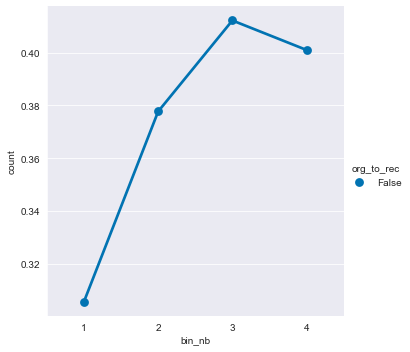

In [77]:
sns.catplot(x="bin_nb", y="count", hue="org_to_rec", kind="point", data=reco_orga_count)

## bin_distrib -- Loop Version -- DEPRECATED

In [179]:
# Ratio calc loop
for user, reco in itertools.product(test_users, recommended_choices):
    # In case of no separation, we pass half of the iterations, which become useless
    if SEPARATE_RECO and reco:
        pass
    try:
        # to_frame() may raise an error on account of the data being size 1 (an int64 cannot be framed)
        if SEPARATE_RECO:
            user_dist = main_dist.loc[(user, reco)].to_frame()
        else:
            user_dist = main_dist[user].to_frame()
        user_dist.columns = ["ratio"]

        # Normalizing with regards to "average" consumption
        user_dist["ratio"] /= bin_distrib * user_dist["ratio"].sum()

        # Log
        user_dist["ratio"] = np.log(user_dist["ratio"])

        # Adding data to total frame for later seaborn plotting (useless for quick-and-dirty mpl)
        user_dist = user_dist.reset_index()
        user_dist["user_id"] = user
        user_dist["recommended"] = reco
        aggregate = pd.concat([aggregate, user_dist], ignore_index=True)
    except AttributeError as e:
        warnings.warn(f"User data of size 1 ignored for user {user}, recommended {reco}")
        pass

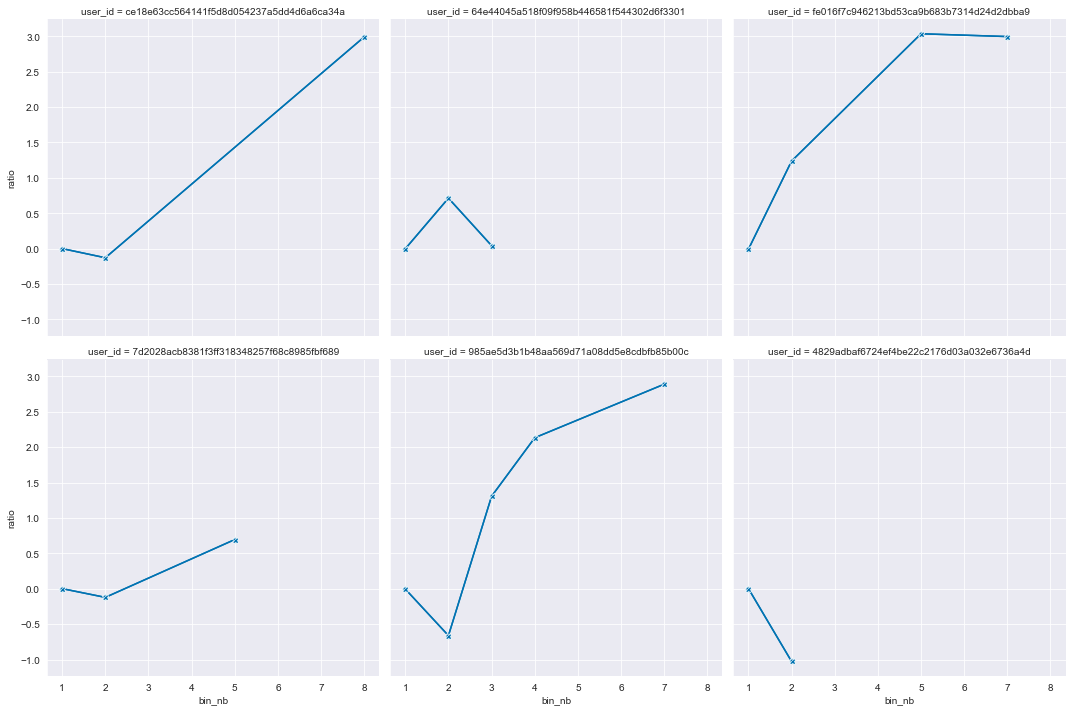

In [92]:
if not SEPARATE_RECO:
    sns.relplot(x="bin_nb", y="ratio", kind="line", col="user_id", col_wrap=3, dashes=False, markers=True,
                estimator=None, data=aggregate, legend=False, style="recommended")
else:
    sns.relplot(x="bin_nb", y="ratio", hue="recommended", style="recommended", kind="line", col="user_id",
                col_wrap=3, dashes=False, markers=True, estimator=None, data=aggregate, legend="brief")
sns.despine()
plt.show()